## PBMA equilibrium

This notebook use Monte Carlo method to simulate the average aggregate capital and average stationary asset distribution with mixed actions.

Last, we also want to compare this with the aggregate capital induced by the stationary asset distribution with mixed actions.



In [1]:
!git clone https://github.com/longye-tian/my-phd

%run my-phd/QHD/PBMA_Ayagari.ipynb
%run my-phd/QHD/transition_dynamics.ipynb

Cloning into 'my-phd'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 376 (delta 55), reused 23 (delta 9), pack-reused 257 (from 1)
Receiving objects: 100% (376/376), 24.63 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (130/130), done.
fatal: destination path 'my-phd' already exists and is not an empty directory.


In [2]:
from tqdm import tqdm

In [14]:
def compute_mixed_action_capital(firm, household, ω=0.5):

    # First, get the CPE Capital, interest rate, wage
    K_continuation, _ = compute_equilibrium_continuation(firm, household)
    r_continuation = r_given_k(K_continuation, firm)
    w_continuation = r_to_w(r_continuation, firm)

    # Compute the CPE prices
    prices_continuation = create_prices(r=r_continuation, w=w_continuation)

    # Get the continuation policy
    σ_c, _ = howard_policy_iteration(household, prices_continuation)

    # Get the short-run policy
    K_short, _ = compute_equilibrium_short(firm, household)
    r_short = r_given_k(K_short, firm)
    w_short = r_to_w(r_short, firm)
    prices_short = create_prices(r=r_short, w=w_short)
    σ_s, _ = compute_lifetime(household, prices_short)

    # Calculate the stationary distribution with mixed actions
    ψ_a = compute_asset_stationary_mixed(σ_s, σ_c, household, ω)

    # Calculate the aggregate capital from this distribution
    K_mixed = float(jnp.sum(ψ_a * household.a_grid))

    return K_mixed, σ_s, σ_c

In [4]:
def calculate_aggregate_capital(ψ_a, a_grid):
    return float(jnp.sum(ψ_a * a_grid))

In [5]:
def update_distribution(ψ, σ, household):
    return update_joint_stationary(ψ, σ, household)

In [15]:
def monte_carlo_simulation(firm, household, ω=0.5, n_simulations=1000,
                          time_periods=1000, burn_in=0, seed=42):
    # Set random seed
    np.random.seed(seed)

    # Get mixed action capital for comparison
    K_mixed, σ_short, σ_continuation = compute_mixed_action_capital(firm, household, ω)
    print(f"Theoretical mixed-action capital level: {K_mixed:.6f}")

    # Unpack household parameters
    β, δ, a_grid, z_grid, Π = household

    # Get the CPE distribution as starting point
    K_continuation, _ = compute_equilibrium_continuation(firm, household)
    r_continuation = r_given_k(K_continuation, firm)
    w_continuation = r_to_w(r_continuation, firm)
    prices_continuation = create_prices(r=r_continuation, w=w_continuation)
    σ_c, _ = howard_policy_iteration(household, prices_continuation)
    ψ_CPE = compute_joint_stationary(σ_c, household)

    # Storage for simulation results
    K_avg_sim = np.zeros(n_simulations)
    K_all_paths = np.zeros((n_simulations, time_periods - burn_in))

    # Run simulations
    for sim in tqdm(range(n_simulations), desc="Running simulations"):
        # Generate policy sequence (1 = short-run, 0 = continuation)
        policy_sequence = np.random.binomial(1, ω, size=time_periods)

        # Initialize distribution
        current_distribution = ψ_CPE.copy()

        # Path of capital
        K_path = np.zeros(time_periods)

        # Simulate economy
        for t in range(time_periods):
            # Calculate current aggregate capital
            a_marginal = jnp.sum(current_distribution, axis=1)
            K_path[t] = float(jnp.sum(a_marginal * a_grid))

            # Update distribution based on policy for this period
            if policy_sequence[t] == 1:
                current_distribution = update_distribution(current_distribution, σ_short, household)
            else:
                current_distribution = update_distribution(current_distribution, σ_continuation, household)

        # Store average capital (after burn-in)
        K_avg_sim[sim] = np.mean(K_path[burn_in:])
        K_all_paths[sim, :] = K_path[burn_in:]

    # Overall average across all simulations
    K_MC = np.mean(K_avg_sim)
    print(f"Monte Carlo estimate of capital level: {K_MC:.6f}")
    print(f"Difference: {abs(K_MC - K_mixed):.6f}")

    # Calculate standard error
    K_std = np.std(K_avg_sim)
    K_se = K_std / np.sqrt(n_simulations)
    print(f"Standard error: {K_se:.6f}")

    # Plot results
    plt.figure(figsize=(12, 8))

    # Plot average capital path
    avg_path = np.mean(K_all_paths, axis=0)
    x = np.arange(len(avg_path))
    plt.plot(x, avg_path, label='Average capital path', linewidth=2)

    # Add mixed capital reference line
    plt.axhline(y=K_mixed, color='r', linestyle='--',
                label=f'Mixed-action capital ({K_mixed:.4f})')

    # Add Monte Carlo average reference line
    plt.axhline(y=K_MC, color='g', linestyle='-.',
                label=f'Monte Carlo average ({K_MC:.4f})')

    # Add confidence interval
    ci_upper = avg_path + 1.96 * np.std(K_all_paths, axis=0) / np.sqrt(n_simulations)
    ci_lower = avg_path - 1.96 * np.std(K_all_paths, axis=0) / np.sqrt(n_simulations)
    plt.fill_between(x, ci_lower, ci_upper, alpha=0.2, color='blue',
                    label='95% Confidence Interval')

    plt.title(f'Monte Carlo Simulation of Capital Path (ω={ω})')
    plt.xlabel('Time periods (after burn-in)')
    plt.ylabel('Aggregate Capital')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot histogram of average capital levels
    plt.figure(figsize=(10, 6))
    plt.hist(K_avg_sim, bins=30, alpha=0.7, color='blue',
             edgecolor='black', density=True)
    plt.axvline(x=K_mixed, color='r', linestyle='--',
                label=f'Mixed-action capital ({K_mixed:.4f})')
    plt.axvline(x=K_MC, color='g', linestyle='-.',
                label=f'Monte Carlo average ({K_MC:.4f})')
    plt.title(f'Distribution of Average Capital Levels (ω={ω})')
    plt.xlabel('Average Capital Level')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

    return {
        'K_mixed': K_mixed,
        'K_MC': K_MC,
        'K_std': K_std,
        'K_se': K_se,
        'K_avg_sim': K_avg_sim,
        'avg_path': avg_path
    }

In [7]:
def run_multiple_omega_values(firm, household, omega_values=None,
                             n_simulations=50, time_periods=800, burn_in=0):
    if omega_values is None:
        omega_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

    results = {}
    K_mixed_values = []
    K_MC_values = []

    for ω in omega_values:
        print(f"\nRunning simulations for ω={ω}")
        result = monte_carlo_simulation(firm, household, ω,
                                       n_simulations, time_periods, burn_in)
        results[ω] = result
        K_mixed_values.append(result['K_mixed'])
        K_MC_values.append(result['K_MC'])

    # Plot comparison of mixed-action vs. Monte Carlo across ω values
    plt.figure(figsize=(10, 6))
    plt.plot(omega_values, K_mixed_values, 'ro-', label='Mixed-action capital')
    plt.plot(omega_values, K_MC_values, 'bo-', label='Monte Carlo estimate')
    plt.xlabel('ω (probability of short-run policy)')
    plt.ylabel('Aggregate Capital')
    plt.title('Comparison of Capital Levels Across ω Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return results

Running a quick test simulation...
Theoretical mixed-action capital level: 5.599449


Running simulations: 100%|██████████| 1000/1000 [07:37<00:00,  2.18it/s]


Monte Carlo estimate of capital level: 5.600577
Difference: 0.001128
Standard error: 0.002721


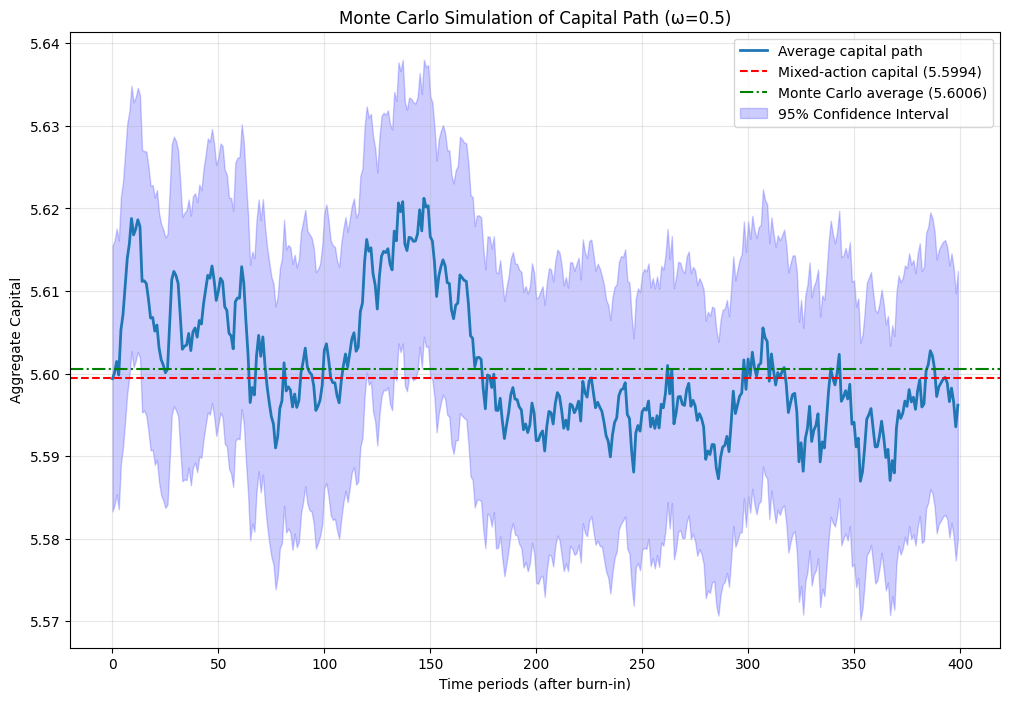

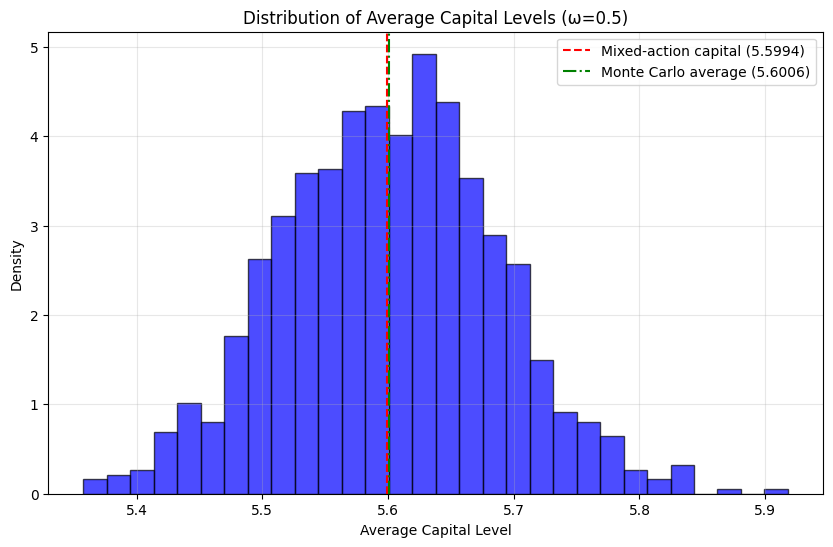

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import time

# Create firm and household
firm = create_firm()
household = create_household()

# Run a quick single simulation with fewer periods for testing
print("Running a quick test simulation...")
quick_result = monte_carlo_simulation(
    firm, household,
    ω=0.5,
    n_simulations=1000,  # Use fewer simulations for quick testing
    time_periods=600,  # Shorter time periods
    burn_in=200
)


Running simulations for multiple omega values...

Running simulation for ω=0.0
Theoretical mixed-action capital level: 8.099381


Running simulations: 100%|██████████| 1000/1000 [07:38<00:00,  2.18it/s]


Monte Carlo estimate of capital level: 8.099381
Difference: 0.000000
Standard error: 0.000000


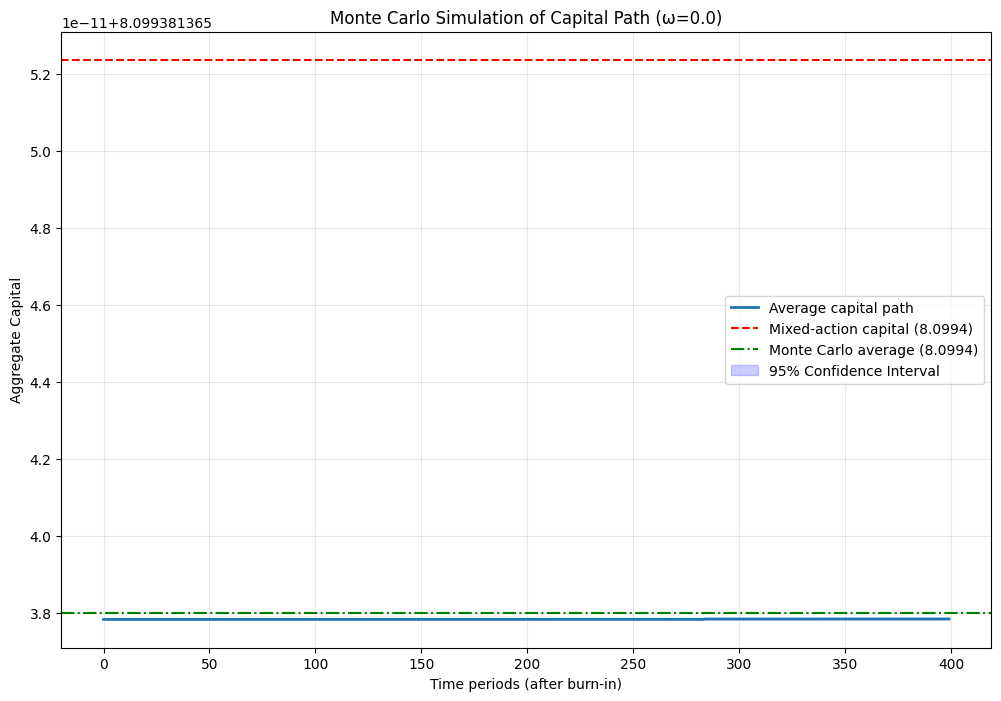

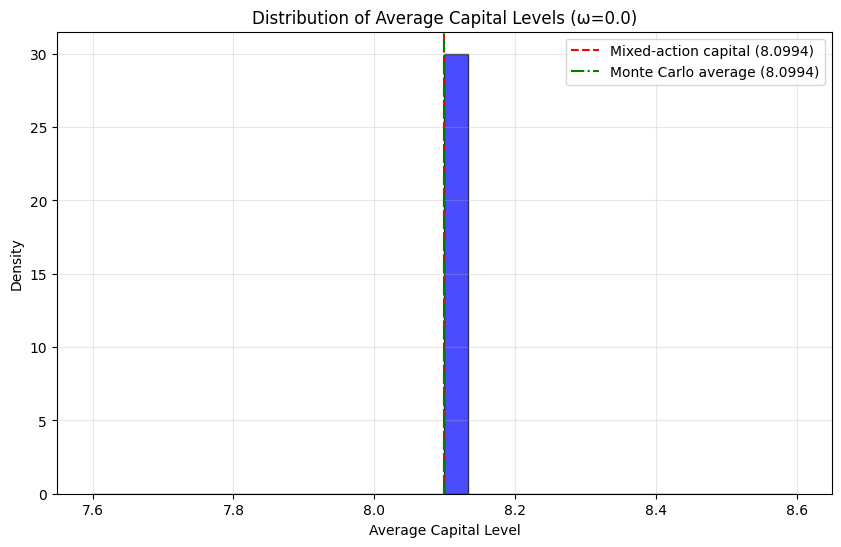

Time taken for ω=0.0: 575.70 seconds

Running simulation for ω=0.2
Theoretical mixed-action capital level: 6.891315


Running simulations: 100%|██████████| 1000/1000 [07:37<00:00,  2.19it/s]


Monte Carlo estimate of capital level: 6.892930
Difference: 0.001615
Standard error: 0.003117


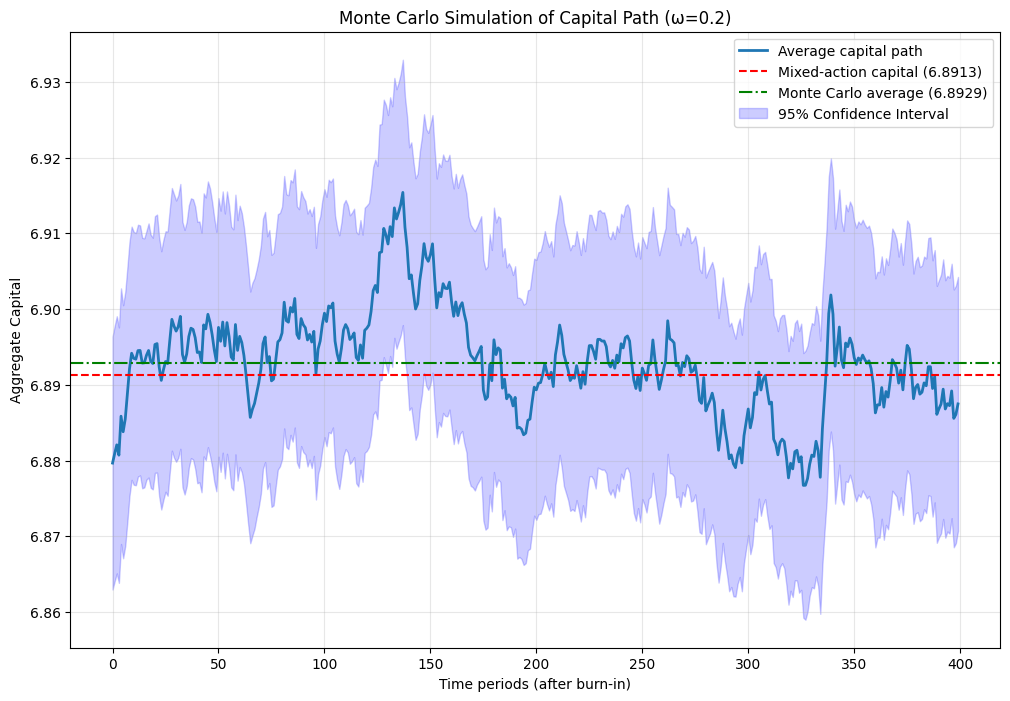

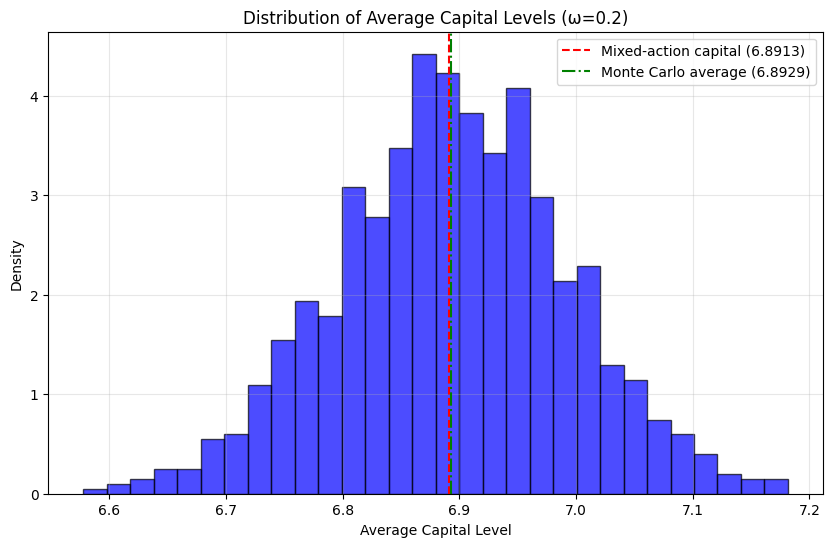

Time taken for ω=0.2: 574.76 seconds

Running simulation for ω=0.5
Theoretical mixed-action capital level: 5.599449


Running simulations: 100%|██████████| 1000/1000 [07:42<00:00,  2.16it/s]


Monte Carlo estimate of capital level: 5.600577
Difference: 0.001128
Standard error: 0.002721


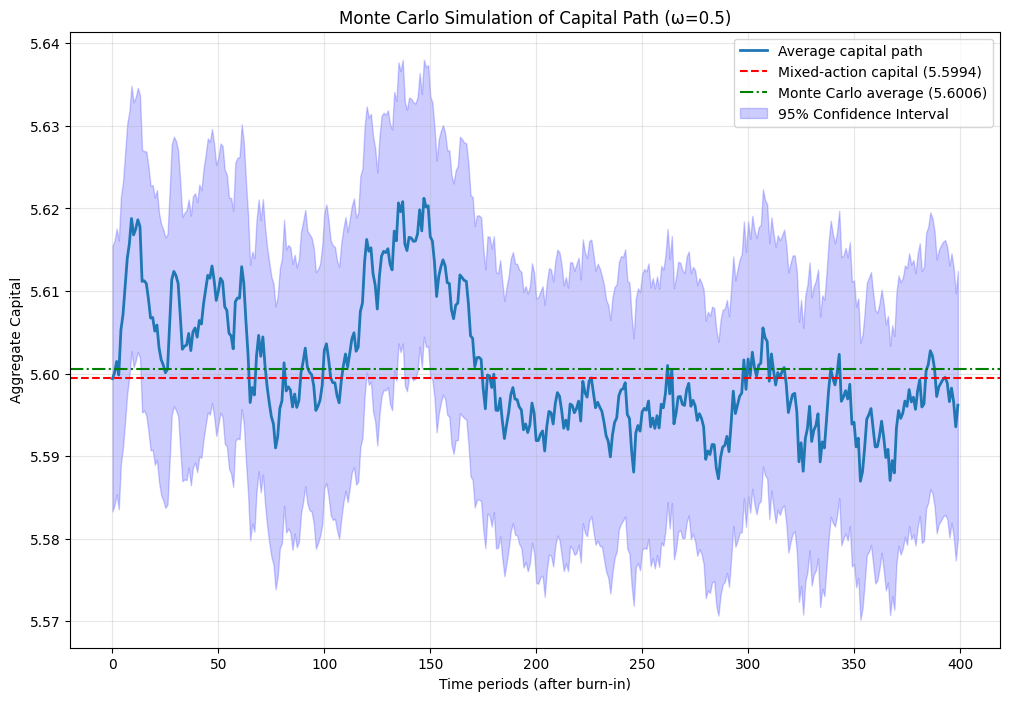

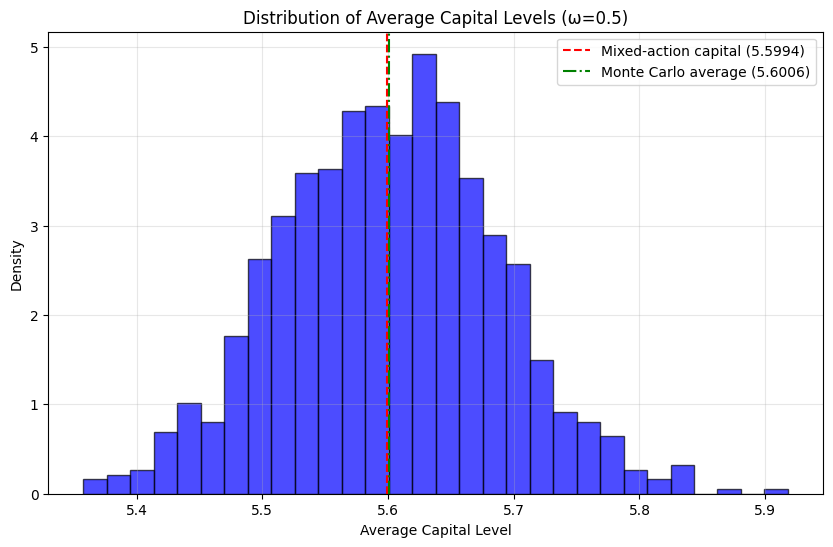

Time taken for ω=0.5: 580.79 seconds

Running simulation for ω=0.8
Theoretical mixed-action capital level: 4.543565


Running simulations: 100%|██████████| 1000/1000 [07:49<00:00,  2.13it/s]


Monte Carlo estimate of capital level: 4.542726
Difference: 0.000839
Standard error: 0.002078


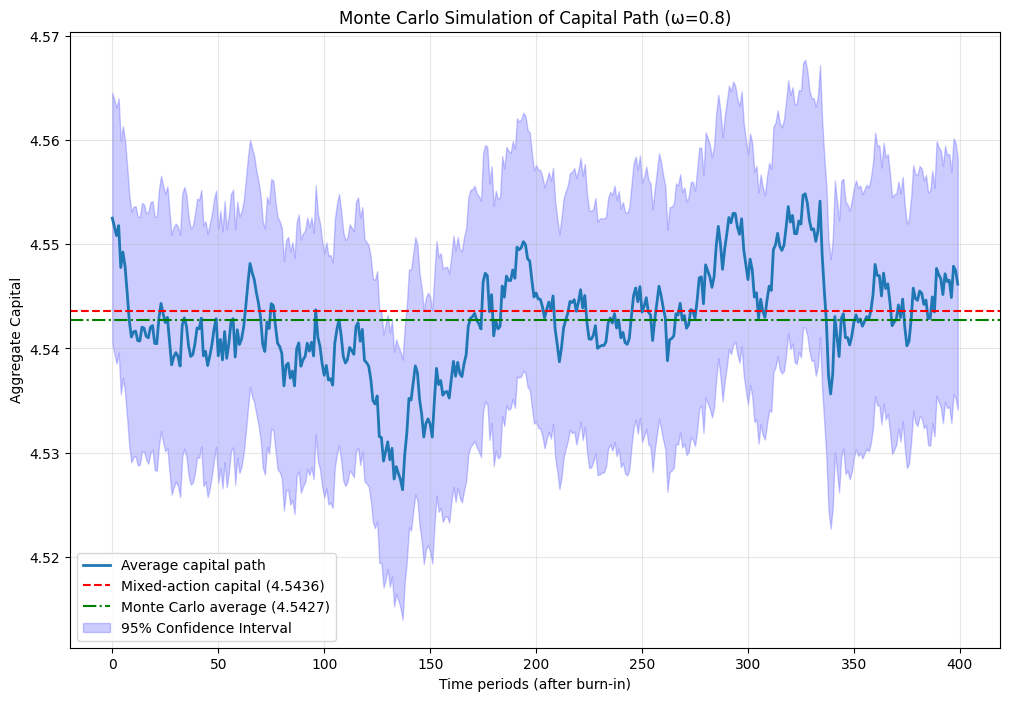

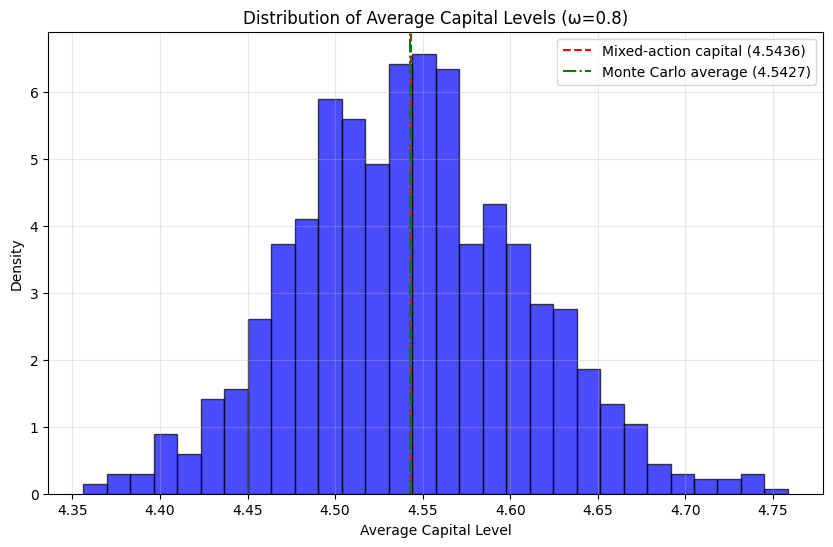

Time taken for ω=0.8: 584.57 seconds

Running simulation for ω=1.0
Theoretical mixed-action capital level: 3.877884


Running simulations: 100%|██████████| 1000/1000 [07:47<00:00,  2.14it/s]


Monte Carlo estimate of capital level: 3.877912
Difference: 0.000028
Standard error: 0.000000


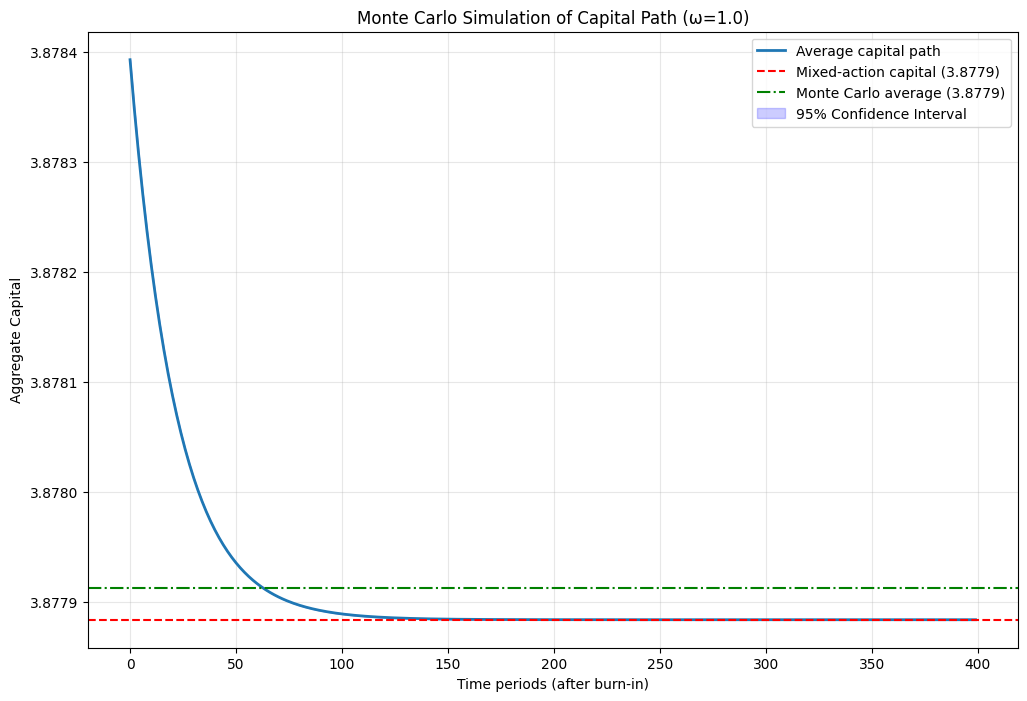

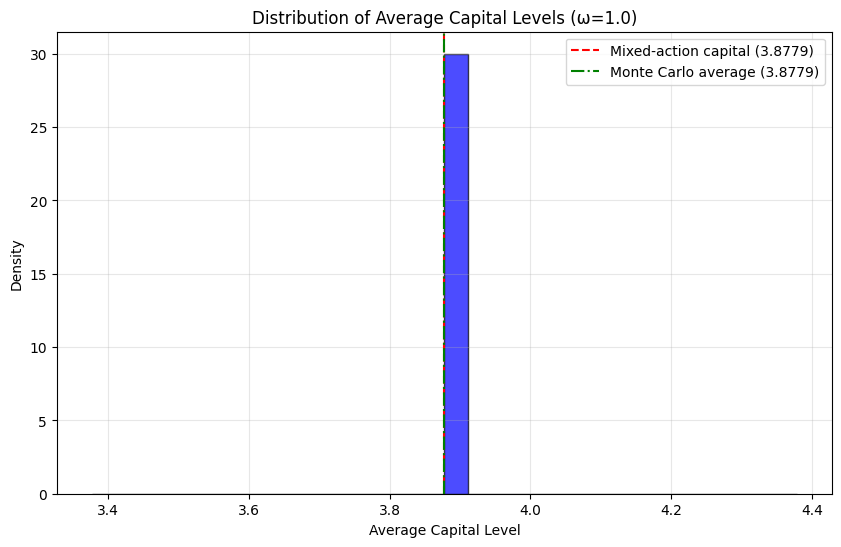

Time taken for ω=1.0: 583.68 seconds

Total time for all simulations: 2899.50 seconds

Summary of Results:
-------------------
ω          K_mixed         K_MC            Difference      Std Error      
----------------------------------------------------------------------
0.0        8.099381        8.099381        0.000000        0.000000       
0.2        6.891315        6.892930        0.001615        0.003117       
0.5        5.599449        5.600577        0.001128        0.002721       
0.8        4.543565        4.542726        0.000839        0.002078       
1.0        3.877884        3.877912        0.000028        0.000000       


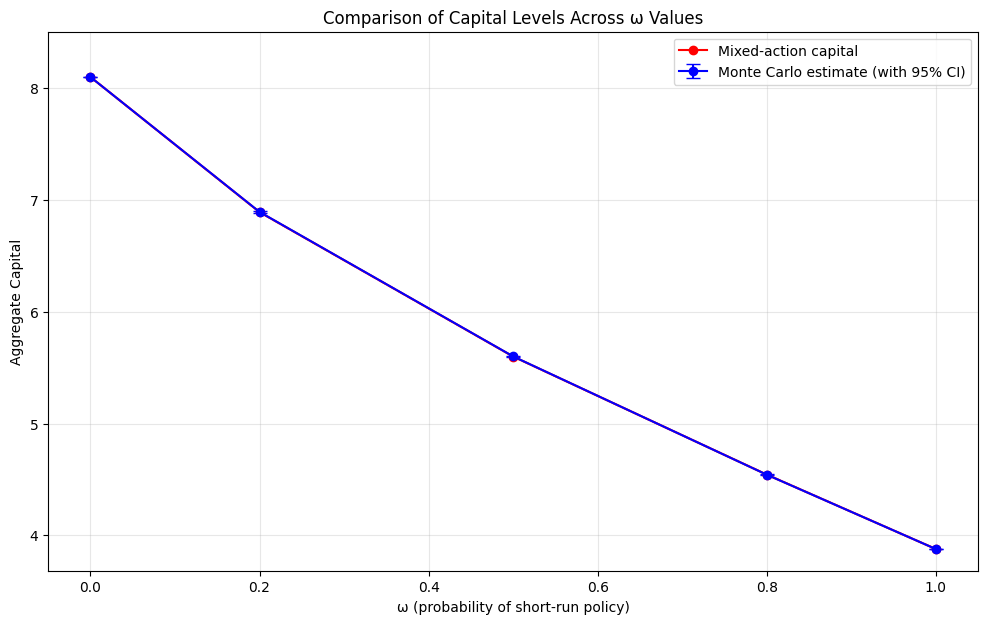


Short-run policy equilibrium capital: 3.887711
Continuation policy equilibrium capital: 8.091825


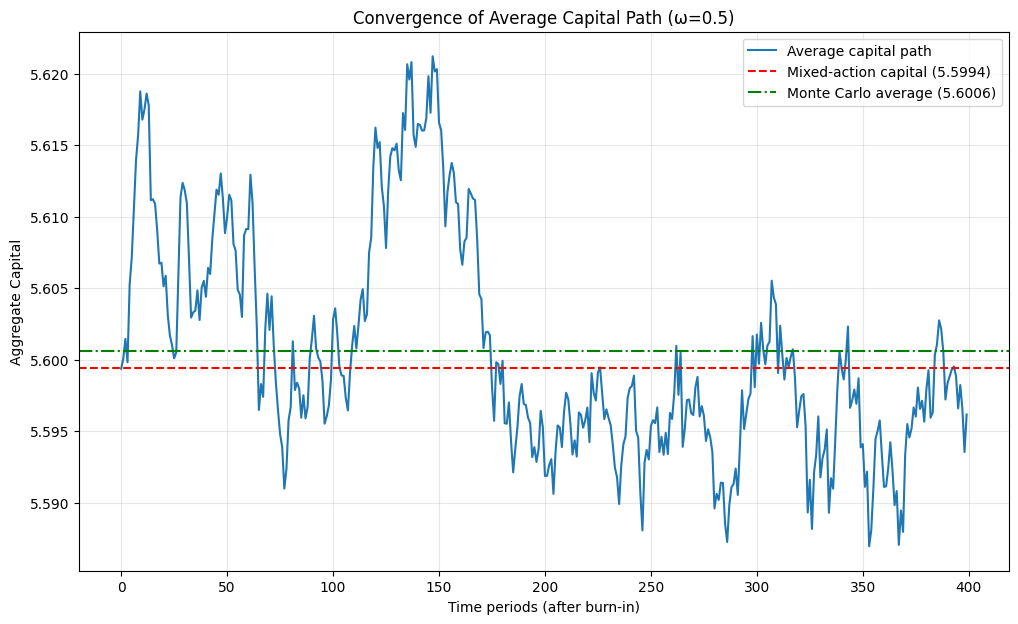

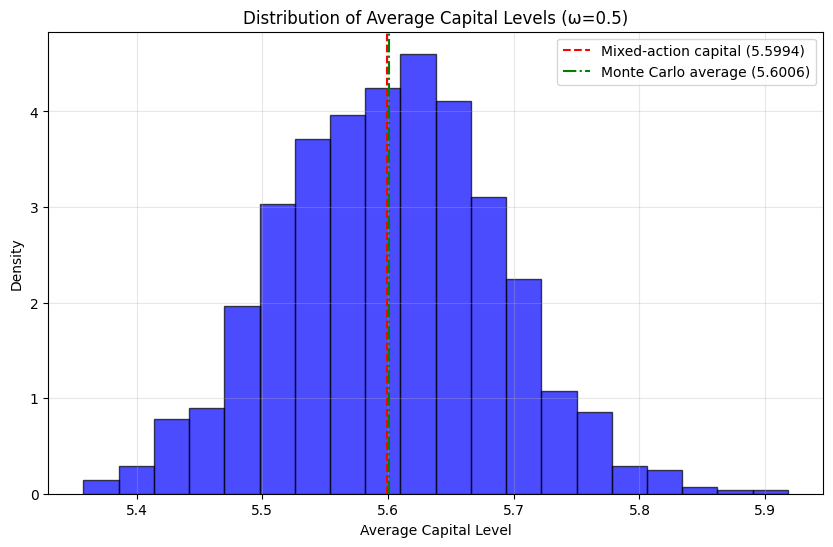

In [18]:
# Run a more comprehensive analysis with multiple omega values
print("\nRunning simulations for multiple omega values...")
omega_values = [0.0, 0.2, 0.5, 0.8, 1.0]
results = {}

# Store timing information
start_time = time.time()
omega_times = []

for ω in omega_values:
    omega_start = time.time()
    print(f"\nRunning simulation for ω={ω}")

    result = monte_carlo_simulation(
        firm, household,
        ω=ω,
        n_simulations=1000,  # Reasonable number for good estimates
        time_periods=600,  # Longer for convergence
        burn_in=200
    )

    results[ω] = result
    omega_time = time.time() - omega_start
    omega_times.append(omega_time)
    print(f"Time taken for ω={ω}: {omega_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nTotal time for all simulations: {total_time:.2f} seconds")

# Create summary table of results
print("\nSummary of Results:")
print("-------------------")
print(f"{'ω':<10} {'K_mixed':<15} {'K_MC':<15} {'Difference':<15} {'Std Error':<15}")
print("-" * 70)

for ω, result in results.items():
    print(f"{ω:<10.1f} {result['K_mixed']:<15.6f} {result['K_MC']:<15.6f} "
          f"{abs(result['K_mixed'] - result['K_MC']):<15.6f} {result['K_se']:<15.6f}")

# Plot K_mixed and K_MC across omega values
K_mixed_values = [results[ω]['K_mixed'] for ω in omega_values]
K_MC_values = [results[ω]['K_MC'] for ω in omega_values]
std_errors = [results[ω]['K_se'] for ω in omega_values]

plt.figure(figsize=(12, 7))
plt.errorbar(omega_values, K_MC_values, yerr=np.array(std_errors)*1.96,
             fmt='bo-', capsize=5, label='Monte Carlo estimate (with 95% CI)')
plt.plot(omega_values, K_mixed_values, 'ro-', label='Mixed-action capital')

# Interpolate to get a smooth curve
fine_omega = np.linspace(0, 1, 100)
# Simple linear interpolation
K_mixed_interp = np.interp(fine_omega, omega_values, K_mixed_values)
plt.plot(fine_omega, K_mixed_interp, 'r--', alpha=0.5)

plt.xlabel('ω (probability of short-run policy)')
plt.ylabel('Aggregate Capital')
plt.title('Comparison of Capital Levels Across ω Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(min(min(K_mixed_values), min(K_MC_values))*0.95,
         max(max(K_mixed_values), max(K_MC_values))*1.05)
plt.savefig('capital_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Check if the equilibrium is unique across the spectrum
K_short, _ = compute_equilibrium_short(firm, household)
K_continuation, _ = compute_equilibrium_continuation(firm, household)

print(f"\nShort-run policy equilibrium capital: {K_short:.6f}")
print(f"Continuation policy equilibrium capital: {K_continuation:.6f}")

# Plot how the average capital path converges for one specific omega value
ω_example = 0.5
result = results[ω_example]

plt.figure(figsize=(12, 7))
plt.plot(result['avg_path'], label='Average capital path')
plt.axhline(y=result['K_mixed'], color='r', linestyle='--',
            label=f'Mixed-action capital ({result["K_mixed"]:.4f})')
plt.axhline(y=result['K_MC'], color='g', linestyle='-.',
            label=f'Monte Carlo average ({result["K_MC"]:.4f})')
plt.title(f'Convergence of Average Capital Path (ω={ω_example})')
plt.xlabel('Time periods (after burn-in)')
plt.ylabel('Aggregate Capital')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('capital_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a histogram of the final distribution for omega = 0.5
plt.figure(figsize=(10, 6))
plt.hist(results[0.5]['K_avg_sim'], bins=20, alpha=0.7, color='blue',
         edgecolor='black', density=True)
plt.axvline(x=results[0.5]['K_mixed'], color='r', linestyle='--',
            label=f'Mixed-action capital ({results[0.5]["K_mixed"]:.4f})')
plt.axvline(x=results[0.5]['K_MC'], color='g', linestyle='-.',
            label=f'Monte Carlo average ({results[0.5]["K_MC"]:.4f})')
plt.title('Distribution of Average Capital Levels (ω=0.5)')
plt.xlabel('Average Capital Level')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('capital_distribution.png', dpi=300, bbox_inches='tight')
plt.show()